<a href="https://colab.research.google.com/github/yunaficus/DRL/blob/main/HW4_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

# hw4-1

In [ ]:
🧾 小報告：以 DQN 強化學習實作簡易環境學習與經驗回放機制
一、前言
本報告探討了以 DQN（Deep Q-Network） 實作強化學習於簡單環境（Gridworld）中的學習歷程與模型訓練架構，並著重於兩個核心重點：

基本 DQN 架構於簡易環境中的應用

引入經驗回放（Experience Replay Buffer）提升學習穩定性與效率

透過 Python、PyTorch 與自定義 Gridworld 環境的整合，這份程式碼展現了由基本強化學習到進階機制的實作過程與效果分析。

二、Basic DQN Implementation for an Easy Environment
2.1 環境介紹：Gridworld
Gridworld 是一個簡單的 4×4 格狀迷宮，包含「玩家起點」、「目標終點」與「陷阱」，代理人（Agent）需學會選擇正確路徑以最大化 reward。環境可設為：

static：固定配置（起點與終點不變）

random：每場隨機產生新迷宮

player：由玩家設定起點終點位置

2.2 DQN 架構設計
DQN 是將傳統 Q-learning 中的 Q 表轉換為神經網路，透過函數近似器處理大型或連續狀態空間。

model = torch.nn.Sequential(
    torch.nn.Linear(64, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 4)
)

輸入層：64 維（將 Gridworld 4×4×4 壓平）

輸出層：4 維，對應四個動作（上、下、左、右）

使用 ReLU 激活函數

損失函數：MSE（均方誤差）

優化器：Adam

2.3 ε-greedy 策略與訓練流程
模型訓練透過 ε-greedy 策略平衡探索與利用：

隨機選動作（探索）或選 Q 值最大者（利用）

每個 epoch 遊戲結束後更新網路，計算 loss 並透過反向傳播優化

學習過程中，ε 值逐步下降，減少探索傾向，最終保留最低 0.1。

三、Experience Replay Buffer
3.1 為什麼需要 Replay Buffer？
傳統 Q-learning 或 DQN 會依照時間順序處理資料，導致資料高度相關，使訓練不穩定。Replay Buffer 的引入可達到以下優勢：

打破資料之間的相關性（破壞時間序列）

重複使用資料（提高樣本效率）

小批量訓練（mini-batch training）加速收斂

3.2 機制與實作

from collections import deque

replay = deque(maxlen=1000)  # 限制大小
minibatch = random.sample(replay, batch_size)  # 隨機抽樣
每一步經驗紀錄為：


(state, action, reward, next_state, done)
當經驗量足夠後，從記憶體中隨機抽取 batch_size 筆資料進行訓練，並依據 Q-learning 更新目標值：

Y = reward_batch + γ * ((1 - done_batch) * max(Q(s′)))
這可避免同樣情況持續出現導致模型偏誤學習。

四、進階設計與優化
4.1 目標網路（Target Network）
進一步引入 Target Network（model2），用於穩定目標 Q 值計算，並每隔固定步數同步參數。


if j % sync_freq == 0:
    model2.load_state_dict(model.state_dict())
4.2 避免撞牆懲罰
透過 validateMove() 判斷是否撞牆，並給予額外懲罰（如 reward = -5），強化代理人避免無效動作。

五、訓練結果與成效
5.1 損失值趨勢
透過繪圖顯示訓練過程中 loss 的下降趨勢，可評估模型收斂狀況。

5.2 測試勝率
在測試階段模擬 1000 次遊戲，統計代理人勝率（到達終點）作為最終模型表現指標。

六、結論與心得
這份程式碼展示了從基本 DQN 到引入經驗回放與目標網路的完整強化學習訓練流程。重點包括：

神經網路模型作為 Q 函數近似器。

經驗回放與隨機抽樣提升學習效率與泛化能力。

避免撞牆、勝率統計等優化手段提升模型實用性。

透過這樣的實驗平台，不僅能夠加深對 DQN 原理的理解，也為日後在複雜環境中實作如 Atari、OpenAI Gym 等強化學習任務打下良好基礎。



# hw4-2
part1 Double DQN implement  
part2 Dueling DQN implement  
paet3 Basic DQN implement  
part4 comparison

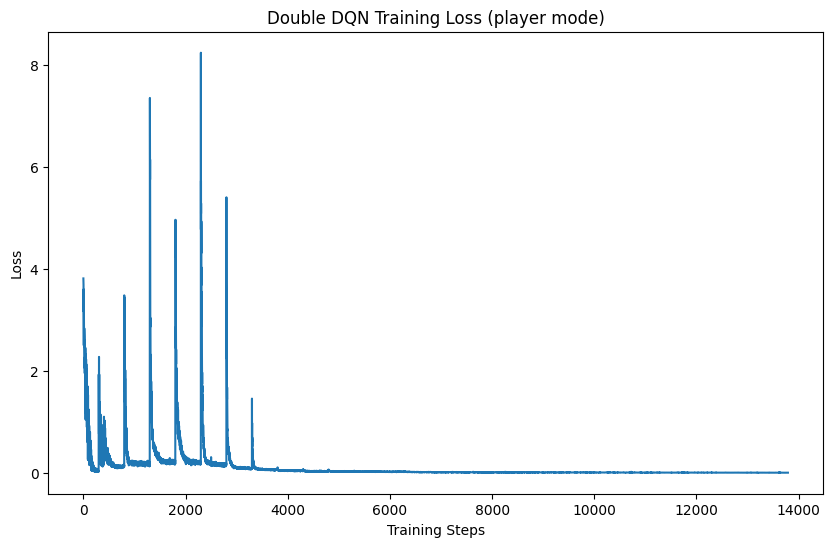

In [3]:
import numpy as np
import torch
import random
import copy
from collections import deque
from Gridworld import Gridworld
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 動作對應表
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

# 模型架構與初始化
L1, L2, L3, L4 = 64, 150, 100, 4  # 網路層維度
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

model2 = copy.deepcopy(model)  # 建立目標網路
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = 0.9
epsilon = 1.0

# 訓練參數
epochs = 1000
batch_size = 200
mem_size = 1000
sync_freq = 500
replay = deque(maxlen=mem_size)
DoubleDQN_losses = []
j = 0  # 記錄步數

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while status == 1:
        j += 1
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = reward != -1

        # 儲存到 Replay Buffer
        replay.append((state1, action_, reward, state2, done))
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

            # --- Double DQN 核心部分 ---
            Q1 = model(state1_batch)
            with torch.no_grad():
                next_actions = torch.argmax(model(state2_batch), dim=1)  # 主網路選動作
                Q2 = model2(state2_batch)
                next_Q = Q2.gather(1, next_actions.unsqueeze(1)).squeeze()
            Y = reward_batch + gamma * ((1 - done_batch) * next_Q)
            X = Q1.gather(1, action_batch.long().unsqueeze(1)).squeeze()
            loss = loss_fn(X, Y.detach())
            # ---------------------------

            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss.item()}")
                clear_output(wait=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            DoubleDQN_losses.append(loss.item())

            # 每 sync_freq 步更新目標網路
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())

        if abs(reward) == 10:
            status = 0

    if epsilon > 0.1:
        epsilon -= 1/epochs

# 繪製 Loss 曲線
plt.figure(figsize=(10, 6))
plt.plot(DoubleDQN_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Double DQN Training Loss (player mode)")
plt.show()
